In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pt

In [2]:
data = pd.read_csv('C:/Users/Drew/Downloads/bandwidth.csv')
data.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


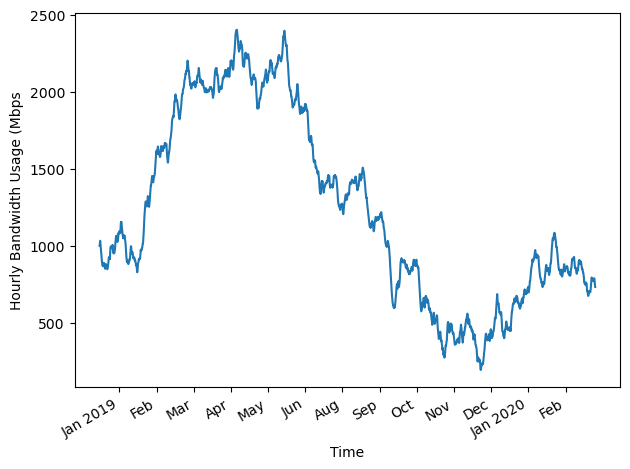

In [3]:
fig , ax = pt.subplots()

ax.plot(data['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly Bandwidth Usage (Mbps')
pt.xticks(np.arange(400, 10000, 750),
          ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])
fig.autofmt_xdate()
pt.tight_layout()

# Complex Time Series 
# Autoregressive Moving Average (ARMA)

When the ACF plot and PACF plot exhibits a slowly decaying pattern or a sinusoidal pattern where we cannot infer an order from it, we are in the presence of an autoregressive moving average (ARMA) process. This process involves model selection using the Akaike Information Criterion (AIC), which will determine the optimal combination of p and q for our time series. Then we must evaluate the model's validity using residual analysis by studying the correlogram, Q-Q plot, and density plot of the model's residuals to assess if they closely resemble white noise. If that is the case, we can move on to forecasting time series using the ARMA(p,q) model.

As per the figure above, we notice that it has a long term trends over time, meaning that this series is likely not stationary, so we need to apply a transformation. Also, there seems to be no cyclical behavior, so we can rule out the presence of seasonality in our series. 

The steps to identify random walk, an MA process or AR process will be the same as MA and AR. 

# Identify a Stationary ARMA Process

The flow will be the same as AR. At the end after plotting the PACF, if the coefficients become abruptly non-significant after lag p, it is an AR(p) process. If it does not abruptly become non-significan, then it is an ARMA(p,q) process.

Let's try and simulate our own ARMA process:

                            yt = 0.33yt-1 + 0.9et-1 + et

                            e(white noise) 

The objective of this simulation is to demonstrate that we cannot use the ACF plot to identify the order q of an ARMA(p,q) process, which in this case is 1, nor can we use the PACF plot to identify the order p of an ARMA(p,q) process, which in this case is also 1.

We will use the ArmaProcess function from the statsmodels library to simulate our ARMA(1,1) process. We'll define the array of coefficients for the AR(1) process, as well as for the MA(1) process. From the equation above, we know that our AR(1) process will have the coefficient of 0.33. However, keep in mind that the function expects to have the coeffecient of the autoregressive process with its opposite sign, as this is how it is implemented in the statsmodels library. Thus, we must put as -0.33. For the moving average portion, the coefficient is 0.9. Also recall that when defining your arrays of coefficients, the first coefficient is always equal to 1, as specified by the library, which represents the coefficient at lag 0. Once our coefficients are defined, we will generate 1000 data points.

In [4]:
from statsmodels.tsa.arima_process import ArmaProcess

np.random.seed(42)
ar1 = np.array([1,-0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [5]:
from statsmodels.tsa.stattools import adfuller

ADF_results = adfuller(ARMA_1_1)

print(f'ADF Statistic: {ADF_results[0]}')
print(f'P-Value: {ADF_results[1]}')

ADF Statistic: -6.42987868204269
P-Value: 1.7078466680096923e-08


Now we know that our time series data is stationary, we can move on to plotting the ACF function

<function plot_acf at 0x000002324F0322A0>


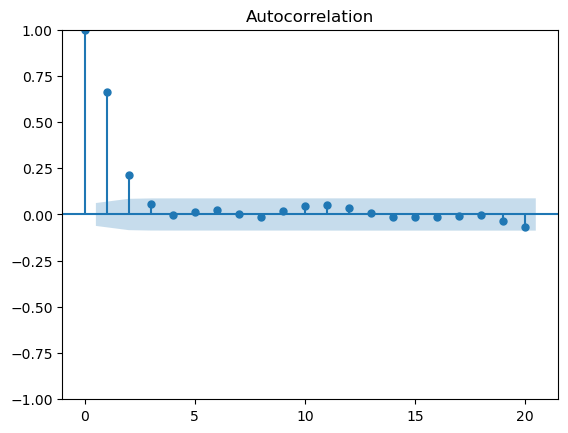

In [6]:
from statsmodels.graphics.tsaplots import plot_acf 

plot_acf(ARMA_1_1, lags=20)
print(plot_acf)

Notice that there is a sinusoidal pattern in the plot, which indicates the presence of an autoregressive process. This is expected because we simulated an ARMA(1,1) process and we know of the existence of the autoregressive portion. Furthermore, you'll notice that the last significant coefficient is at lag 2. However, we know that our simulated data has an MA(1) process, so we would expect to have significant coefficients up to lag 1 only. We can thus conclude that the ACF plot does not reveal any useful information about the order q of our ARMA(1,1) process. 

We can now move on to the next step and plot the PACF. Previously while doing the AR process, we learned that the PACF can be used to find the order of a stationary AR(p) process. We will now verify whether we can find the order p of our simulated ARMA(1,1) process, where p=1.

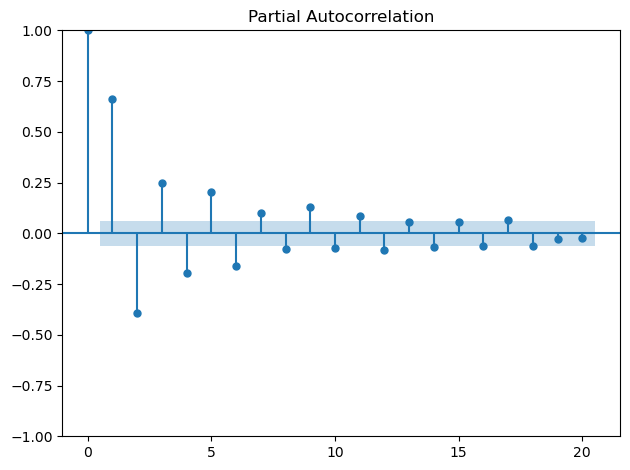

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(ARMA_1_1, lags=20)
pt.tight_layout()

We can also see a clear sinusoidal pattern in this PACF, meaning that we cannot infer a value for the order p. We know that we simulated an ARMA(1,1) process, but we cannot determine that value from the PACF plot above, since we have significant coefficients past lag 1. Therefore, the PACF plot cannot be used to find the order p of an ARMA(p,q) process. 

According to the steps flowchart, since there is no clear cutoff between significant and non-significant coefficients in both the ACF and PACF plots, we can conclude that we have an ARMA(p,q) process, which is indeed the case.

# Devising a general modeling procedure

As per above, we saw that if both the ACF and PACF plots display a sinusoidal or decaying pattern, our time series can be modeled by an ARMA(p,q) process. However, neither plot was useful for determining the orders p and q. Without simulated ARMA(1,1) process, we noticed that coefficients were significant after lag 1 in both plots. Thus, we must devise a procedure that allows us to find orders p and q. This procedure will have the advantage that it can also be applied in situations where our time series is non-stationary and has seasonal effects.

The first few steps remain unchanged from those we gradually built up like MA and AR process. We must still gather data, test for stationarity, and apply transformations accordingly. Then we list different possible values for p and q (note that they only take positive integers). With a list of possible values, we can fit every unique combination of ARMA(p,q) to our data.

Once that is done, we can compute the Akaike Information Criterion (AIC), which is a technique to select the optimal model. It quantifies the quality of each moedl in relation to each other and the model with the lowest AIC is then selected. From there, we can analyze the model's residuals, which is the difference between the actual and predicted values of the model. Ideally, the residuals will look like white noise, which would mean that any difference between the predicted values and actual values is due to randomness. Therefore, the residuals must be uncorrelated and independently distributed. We can assess those properties by studying the quantile-quantile plot (Q-Q plot) and running the Ljung-Box test. If the analysis leads us to conclude that the residuals are completely random, we have a model ready for forecasting. Otherwise, we must try a different set of values for p and q and start over the process.

In [8]:
from itertools import product

ps = range(0,4,1) #Create a list of possible values for p starting from 0 inclusively to 4 exclusively, with steps of 1
qs = range(0,4,1) #Create a list of possible values of q starting from 0 inclusively to 4 exclusively, with steps of 1


order_list = list(product(ps, qs))

In [9]:
#Function to fit all unique ARMA(p,q) models
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    #Initialize an empty list to store the order (p,q) and its corresponding AIC as a tuple
    results = [] 
    
    #Iterate over each unique (p,q) combination. The use of tqdm_notebook will display a progress bar.
    for order in tqdm_notebook(order_list): 
        try:
            #simple_differencing = False to prevent differencing
            #disp=False to avoid printing convergence messages to the console
            model = SARIMAX(endog, order=(order[0], 0, order[1]),
                            simple_differencing = False).fit(disp=False)
        except:
            continue
        
        aic = model.aic #Calculate the model's AIC
        results.append([order,aic]) #Append the (p,q) combination and AIC as a tuple to result list
    
    result_data = pd.DataFrame(results) #Store the combination in a DataFrame
    result_data.columns = ['(p,q)', 'AIC'] #Label the columns of the DataFrame
    
    #Sort in ascending order, lower AIC is better
    result_data = result_data.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_data

In [10]:
result_data = optimize_ARMA(ARMA_1_1, order_list)
result_data

C:\Users\Drew\AppData\Local\Temp\ipykernel_5404\1216436277.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.068068
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


As we can see from the AIC, we can say that an ARMA(1,1) model is the best model relative to all other models that we fit to our data because it has the lowest AIC. Now we need an absoluate measure of the model's quality. This bring us to the next step of our modeling process, which is residual analysis.

# Understanding Residual Analysis

This is the last step before forecasting, which is residual analysis and answering the two questions in the flowchart: does the Q-Q plot show a straight line, and are the residuals uncorrelated? If the answer to both questions is yes, then we have a model that is ready to make forecasts. Otherwise, we must try different combinations of (p,q) and restart the process.

The residuals of a model are simply the difference between the predicted values and the actual values. For example, consider our simulated ARMA(1,1) expressed as: 

                       yt = 0.33yt + 0.9et-1 + et
                       
And suppose that we fit an ARMA(1,1) model to our process and we estimate the model's coefficient perfecly, such that the model is express as:
                             
                       yhat = 0.33yt-1 + 0.9et-1
                       
The residuals will be the difference between the values coming from our model and the observed values from our simulated process.

                residuals = 0.33yt-1 + 0.9et-1 + et - (0.33yt-1 + 0.9)
                residuals = et
                
In perfect situations, the residuals of a model are white noise. This indicates that the model has captured all predictive information, and there is only a random fluctuation left that cannot be modeled. Thus, the residuals must be uncorrelated and have a normal distribution in order for us to conclude that we have a good model for making forecasts

There are two aspect to residual analysis: 

- Qualitative Analysis: focuses on studying the Q-Q plot
- Quantitative Analysis: determines whether our residuals are uncorrelated

# Qualitative Analysis
# Quantile-Quantile plot (Q-Q plot) 

The Q-Q plot is a plot of the quantiles of two distributions against each other. In time series forecasting, we plot the distribution of our residuals on the y-axis against the theoretical normal distribution on the x-axis.

This graphical tool allows us to assess the goodness of fit of our model. If the distribution of our residuals is similar to a normal distribution, we will see a straight line lying on y=x. This means that our model is a good fit, becaues the residuals are similar to white noise. 

On the other hand, if the distribution of our residuals is different from a normal distribution, we will see a curved line. We can then conclude that our model is not a good fit, since the residuals' distribution is not as close to a normal distribution, and therefore the residuals are not similar to white noise. 

# Quantitative Analysis 
# Ljung-Box Test

The Ljung-Box test is a statistical test that determines whether the autocorrelation of a group of data is significantly different from 0

In time series forecasting, we apply the Ljung-Box test on the model's residuals to test whether they are similar to white noise. The null hypothesis states that the data is independently distributed, meaning that there is no autocorrelation. If the p-value is larger than 0.05, we cannot reject the null hypothesis, meaning that the residuals are independently distributed. Therefore, there is no autocorrelation, the residuals are similar to white noise, and the model can used for forecasting. 

If the p-value is less than 0.05, we reject the null hypothesis, meaning that our residuals are not independently distributed and are correlated. The model cannot be used for forecasting.

The Ljung-Box test will return a Ljung-Box statistic and a p-value. 


# Performing Residual Analysis

In [11]:
#order = (p, d, q) 
#d = differencing, since we are not doing any differencing, it is 0
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid #Store the model's residuals

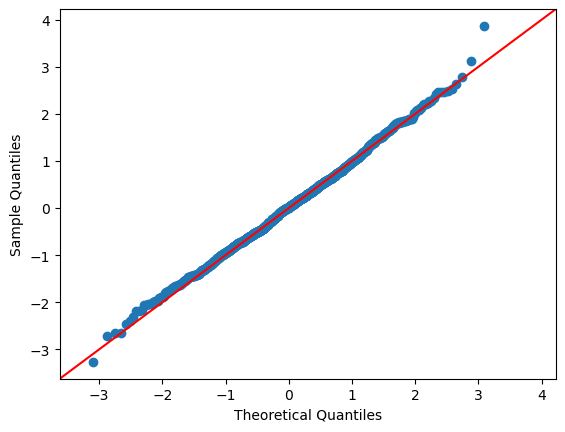

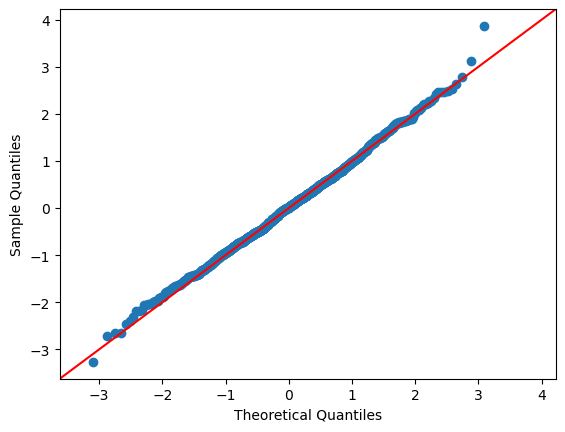

In [12]:
#Plotting the Q-Q plot
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45') #plot the Q-Q plot of the residuals. Specify the display of the line y=x

Q-Q Plot of our ARMA(1,1) residuals. You can see a thick straight line lying on y=x. This means that our residuals are normally distributed, just like white noise.

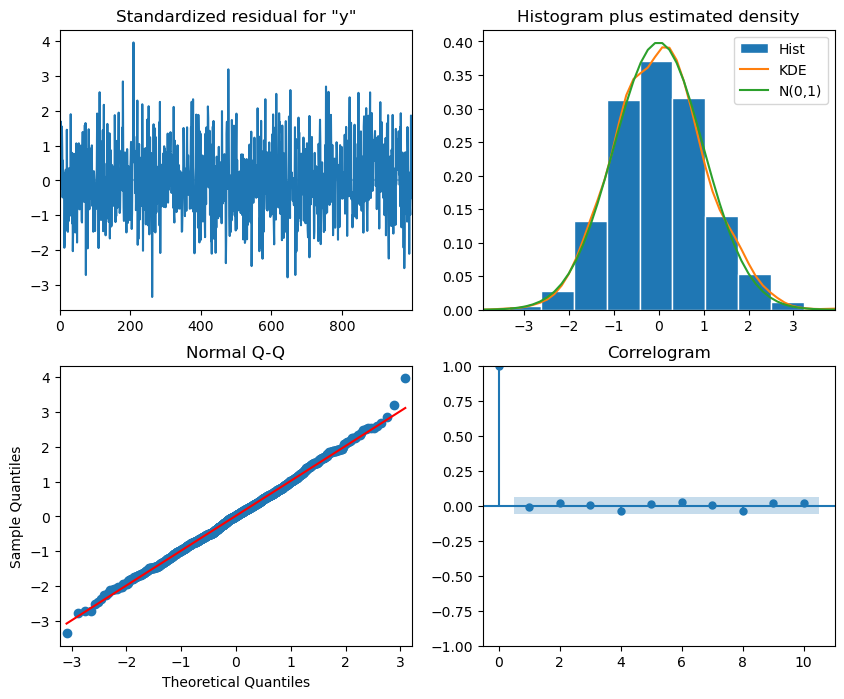

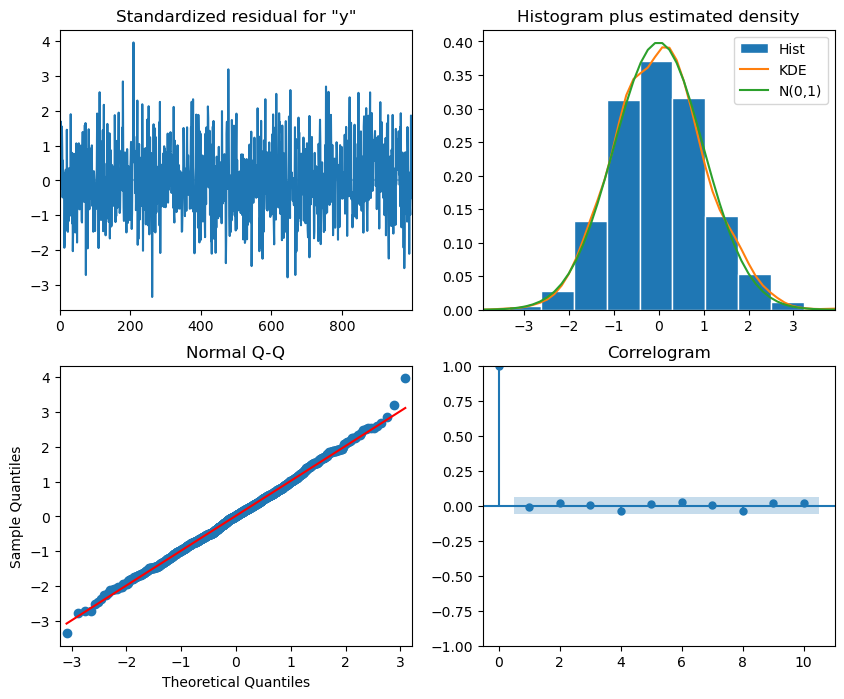

In [13]:
model_fit.plot_diagnostics(figsize=(10,8))

The top left (Standardized resdual for 'y') shows the residuals across the entire dataset. You can see there is no trend, and the mean seems stable over time, which is indicative of stationarity, just like white noise.

The top right (Histogram plus estimated density) shows a histogram of the residuals. You can see the shape of a normal distribution on this plot, which again indicates that the residuals are close to white noise, as white noise is normally distributed as well.

At the bottom left, we have the Q-Q plot, which is the same as the Q-Q plot above.

At the bottom right (Correlogram), shows the autocorreltaion function of our residuals. You can see there is only a significant peak at lag 0, and no significant coefficients otherwise. This means that the residuals are not correlated, which further supports the conclusion that they are similar to white noise, which is what we expect from a good model.

The final step of residual analysis is applying the Ljung-Box test on the residuals. The function takes the residuals as input as well as list of lags. Here we will compute the Ljung-Box statistic and p-value for 10 lags.

In [14]:
from statsmodels.stats.diagnostic import acorr_ljungbox

#Apply the Ljung-Box test on the residuals, on 10 lags
lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


Apparently, the output has bugged but all 10 lags p-values are more than 0.05.  Which mean we cannot reject the null hypothesis for each lag and that the residuals are independently distributed and there is not correlation.

We can conclude that from our analysis that the residuals are similar to white noise. The Q-Q plot showed a straight line, meaning that the residuals are normally distributed. Furthermore, the Ljung-Box test shows that the residuals are uncorrelated, just like white noise. Thus, the residuals are completely random, meaning that we have a model that fits our data well.

Now, let's apply the same modeling procedure to the bandwidth dataset.

# Applying the General Modeling Procedure

- Gather data
- Apply transformation if not stationary
- List values of p and q
- Fit every combination of ARMA(p,q)
- Select model with the lowest AIC
- Residual Analysis
- Restart the process if Q-Q plot shows a straight line or There is uncorrelated residuals
- If everything is fine, ready to forecast

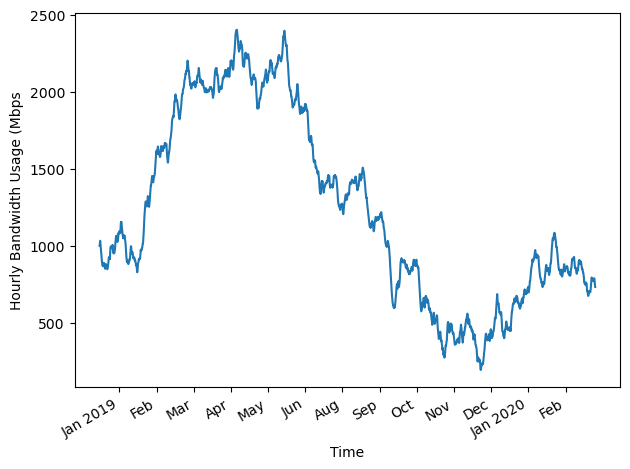

In [16]:
fig , ax = pt.subplots()

ax.plot(data['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly Bandwidth Usage (Mbps')
pt.xticks(np.arange(400, 10000, 750),
          ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])
fig.autofmt_xdate()
pt.tight_layout()

In [18]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(data['hourly_bandwidth'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'P-Value: {ADF_result[1]}')

ADF Statistic: -0.8714653199452924
P-Value: 0.7972240255014491


In [35]:
bandwidth_diff = np.diff(data['hourly_bandwidth'], n=1)

In [36]:
ADF_result = adfuller(bandwidth_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'P-Value: {ADF_result[1]}')

ADF Statistic: -20.694853863789014
P-Value: 0.0


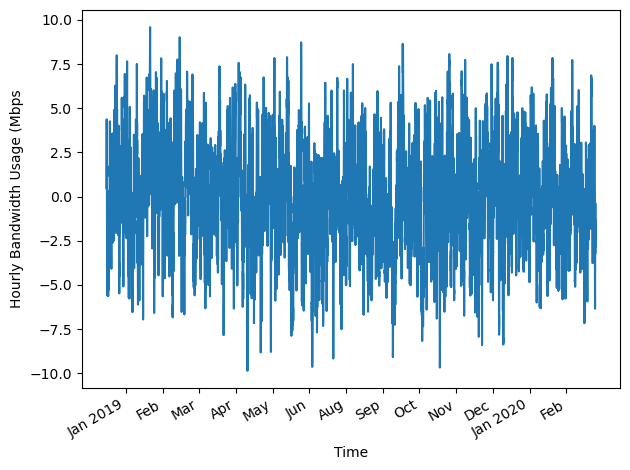

In [37]:
fig , ax = pt.subplots()

ax.plot(bandwidth_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly Bandwidth Usage (Mbps')
pt.xticks(np.arange(400, 10000, 750),
          ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])
fig.autofmt_xdate()
pt.tight_layout()

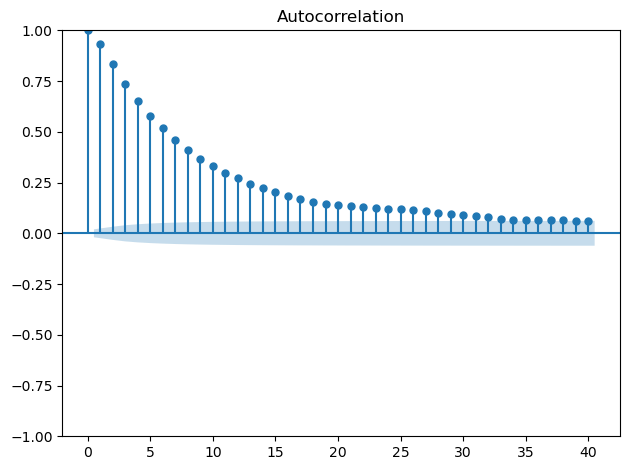

In [38]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(bandwidth_diff)
pt.tight_layout()

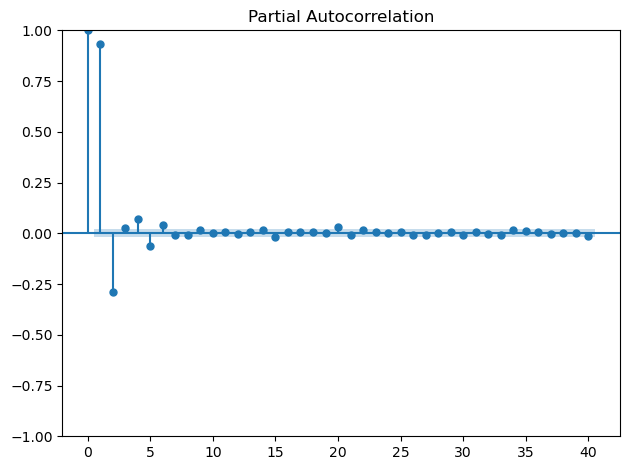

In [39]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(bandwidth_diff)
pt.tight_layout()

In [41]:
data_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = data_diff[:-168]
test = data_diff[-168:]

print(len(train))
print(len(test))

9831
168


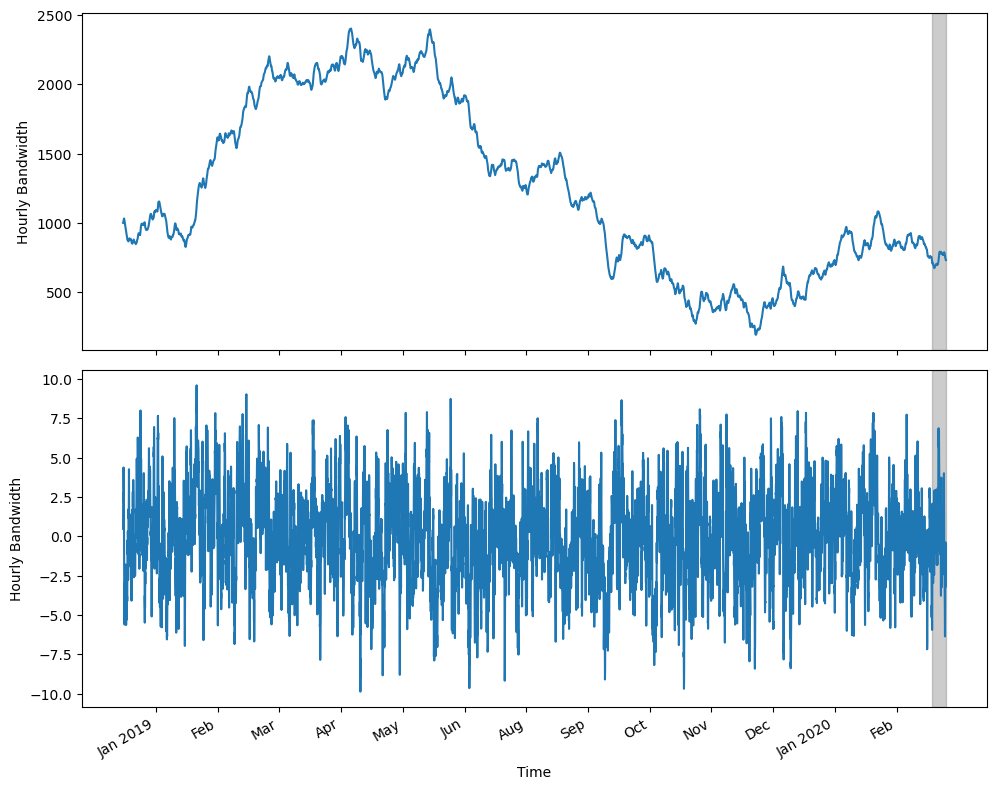

In [53]:
fig, (ax1, ax2) = pt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(data['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly Bandwidth')
ax1.axvspan(9831, 10000, color="#808080", alpha=0.4)

ax2.plot(data_diff['bandwidth_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly Bandwidth')
ax2.axvspan(9830, 9999, color="#808080", alpha=0.4)
pt.xticks(np.arange(400, 10000, 750),
          ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
pt.tight_layout()

In [55]:
#Function to fit all unique ARMA(p,q) models
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    #Initialize an empty list to store the order (p,q) and its corresponding AIC as a tuple
    results = [] 
    
    #Iterate over each unique (p,q) combination. The use of tqdm_notebook will display a progress bar.
    for order in tqdm(order_list): 
        try:
            #simple_differencing = False to prevent differencing
            #disp=False to avoid printing convergence messages to the console
            model = SARIMAX(endog, order=(order[0], 0, order[1]),
                            simple_differencing = False).fit(disp=False)
        except:
            continue
        
        aic = model.aic #Calculate the model's AIC
        results.append([order,aic]) #Append the (p,q) combination and AIC as a tuple to result list
    
    result_data = pd.DataFrame(results) #Store the combination in a DataFrame
    result_data.columns = ['(p,q)', 'AIC'] #Label the columns of the DataFrame
    
    #Sort in ascending order, lower AIC is better
    result_data = result_data.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_data

In [56]:
from itertools import product

ps = range(0,4,1) #Create a list of possible values for p starting from 0 inclusively to 4 exclusively, with steps of 1
qs = range(0,4,1) #Create a list of possible values of q starting from 0 inclusively to 4 exclusively, with steps of 1


order_list = list(product(ps, qs))

In [57]:
result_data = optimize_ARMA(train['bandwidth_diff'], order_list)
result_data

  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


Notice that the first 3 AIC has very similar AIC? Normally, we would want to go for the first place. However, the (2,2) order is relatively close to the champion (3,2) order. Hence, in this case we can take (2,2) order as its AIC value is very close to the (3,2) order while being less complex. Since it just has four parameters to be estimated instead of five. Therefore, we will select the (2,2) order model and move on to the next steps.

In [60]:
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

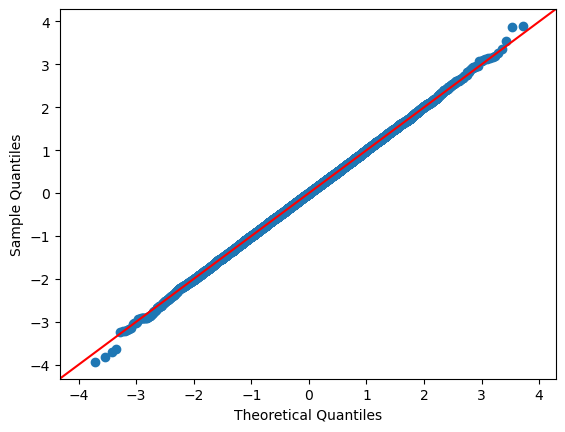

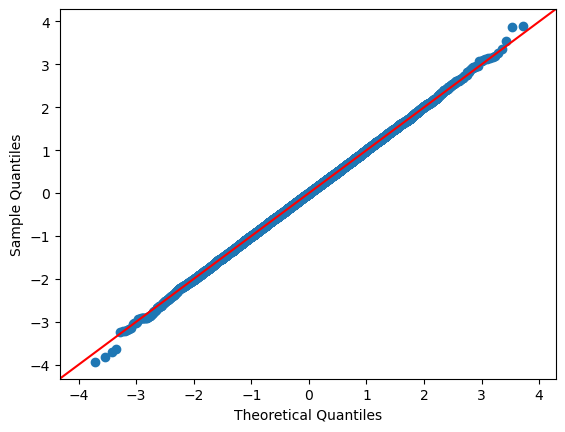

In [61]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45')

In [69]:
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13990.802
Date:                Thu, 25 Apr 2024   AIC                          27991.604
Time:                        14:40:55   BIC                          28027.570
Sample:                             0   HQIC                         28003.788
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

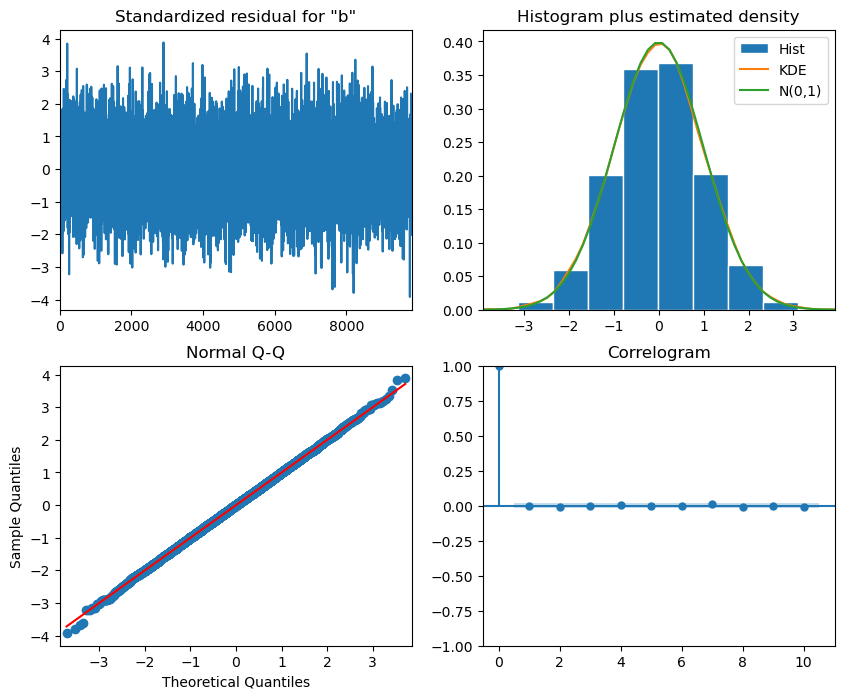

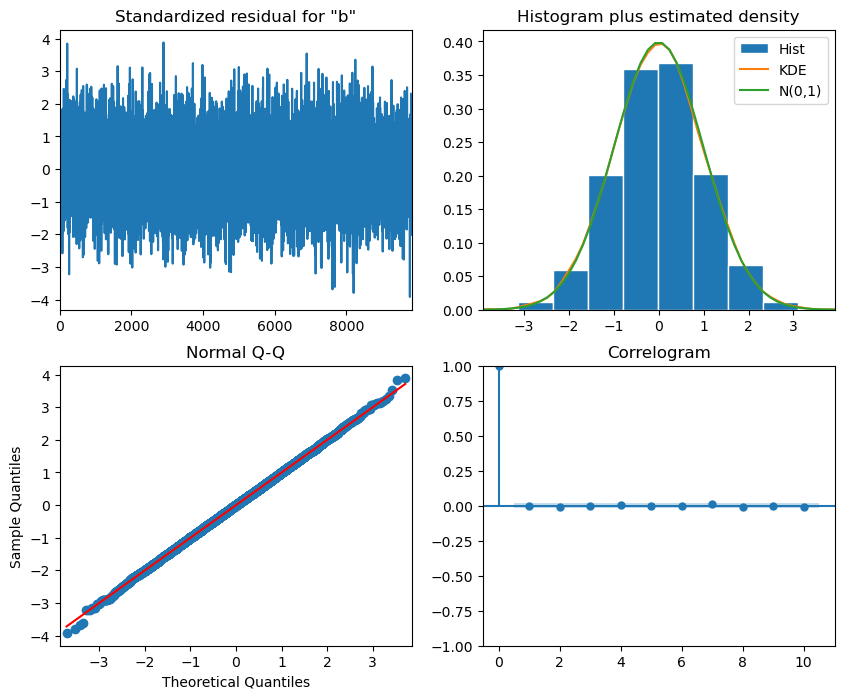

In [63]:
model_fit.plot_diagnostics(figsize=(10,8))

As we can see from the standardize residuals, there is no trend and the mean seems stable over time. Which indicates stationarity, just like white noise.

From the Histogram, we can see the shape of a normal distribution on this plot, which again indicates that the residuals are close to white noise, as white noise is normally distributed as well.

According to the Q-Q plot, we can see that the thick straight line is very close to the y=x line. Which indicates that the residuals are similar to the white noise. This is because we are comparing the distribution to a normal distribution (white noise). 

In the correlogram, we can see there is only a significant peak at lag 0, and no significant coefficients whatsoever. This means that the residuals are not correlated, which further supports the conclusion that they are similar to white noise.

In [68]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid
lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1,11,1))
print(pvalue)

lb_pvalue


According to the book, the p-values all exceed 0.05. Therefore, we can conclude that our residuals are indeed uncorrelated. Our ARMA(2,2) model has passed all the checks on the residual analysis, now we are ready to forecast.

# Forecasting Bandwidth Usage

We will use the ARMA(2,2) model to forecast the next 2 hours of bandwidth usage over 7 days. We will reuse the rolling_forecast function previously from MA and AR. This function allows us to forecast a few timesteps at a time, until we have forecasts for the entire horizon. Also, we'll compare the model's performance to two benchmarks: mean and last known value. This will allow us to make sure that an ARMA(2,2) model performs better than the naive forecasting methods.

In [72]:
#The function takes in a DataFrame containing the full simulated moving average process. 
#Train_len: have to pass in the length of training set
#Horizon: have to pass in the length of test set
#Window: How many timesteps we want to predict
#Method: the method we are using
def rolling_forecast(data: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon

    if method == 'mean' :
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(data[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = data[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range (window))
        return pred_last_value

    elif method == 'ARMA':
        pred_ARMA= []
        for i in range(train_len, total_len, window):
            model = SARIMAX(data[:i], order = (2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
        return pred_ARMA

In [73]:
pred_data = test.copy()
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(data_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(data_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(data_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

pred_data['pred_mean'] = pred_mean
pred_data['pred_last'] = pred_last
pred_data['pred_ARMA'] = pred_ARMA


In [74]:
pred_data.head()

,bandwidth_diff,pred_mean,pred_last,pred_ARMA
9831,-5.943995,-0.028214,-5.791207,-5.460661
9832,-5.865194,-0.028214,-5.791207,-4.890626
9833,-3.197066,-0.029410,-5.865194,-5.335905
9834,-1.090197,-0.029410,-5.865194,-4.751731
9835,0.665291,-0.029840,-1.090197,-0.375596


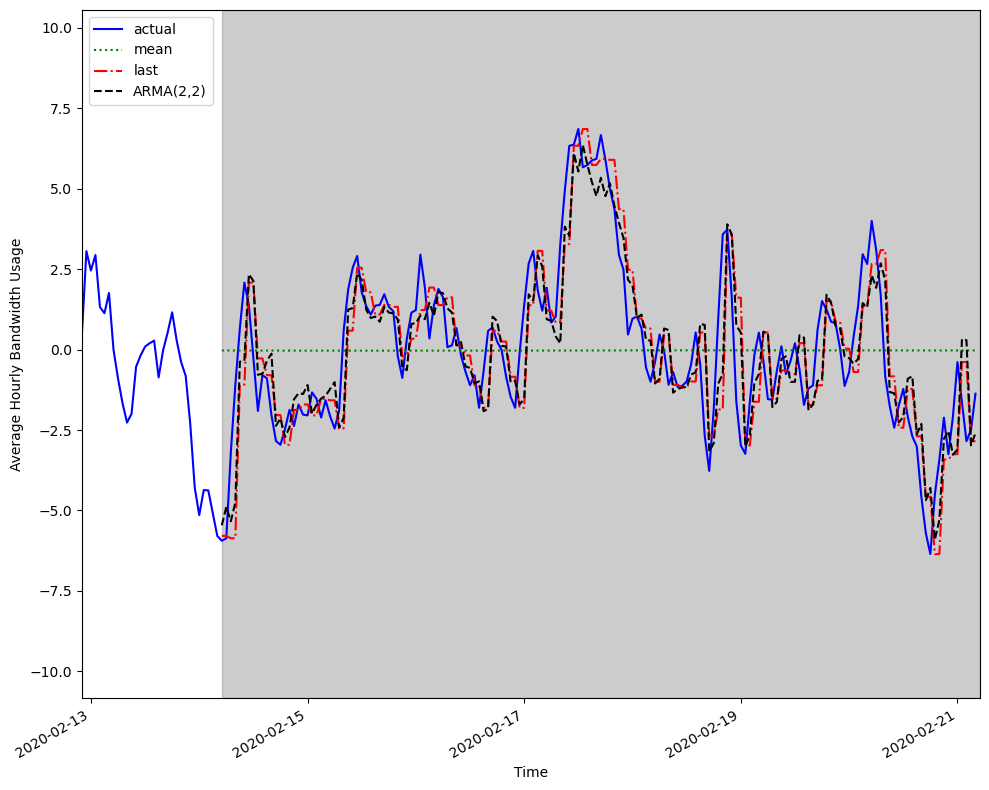

In [77]:
fig, ax = pt.subplots(figsize=(10,8))

ax.plot(data_diff['bandwidth_diff'], 'b-', label='actual')
ax.plot(pred_data['pred_mean'], 'g:', label='mean')
ax.plot(pred_data['pred_last'], 'r-.', label='last')
ax.plot(pred_data['pred_ARMA'], 'k--', label='ARMA(2,2)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Average Hourly Bandwidth Usage')
ax.axvspan(9831, 9999, color="#808080", alpha=0.4)
ax.set_xlim(9800, 9999)
pt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])
fig.autofmt_xdate()
pt.tight_layout()

Now, we will measure the Mean Squared Error to evaluate the performance of each model. The model with the lowest MSE is the best-performing model. 

In [81]:
from sklearn.metrics import mean_squared_error

mean_mse = mean_squared_error(pred_data['bandwidth_diff'], pred_data['pred_mean'])
mean_last = mean_squared_error(pred_data['bandwidth_diff'], pred_data['pred_last'])
mean_ARMA = mean_squared_error(pred_data['bandwidth_diff'], pred_data['pred_ARMA'])

print("The MSE of Mean is: ", mean_mse)
print("The MSE of Last is: ", mean_last)
print("The MSE of ARMA is: ", mean_ARMA)

The MSE of Mean is:  6.306526957989325
The MSE of Last is:  2.2297582947733656
The MSE of AR is:  1.7690462113321535


As per result, ARMA(2,2) achieved the lowest MSE with 1.77 which can then conclude that ARMA(2,2) is the best performing model in this scenario. The final step is to reverse transform the data back to the original scale, as you know, once again in business setting you cant present the differenced value output as stakeholders will not understand.

As usual, to reverse the differencing transformation, we can apply a cumulative sum.

In [83]:
data['pred_bandwidth'] = pd.Series()
data['pred_bandwidth'][9832:] = data['hourly_bandwidth'].iloc[9832] + pred_data['pred_ARMA'].cumsum()

C:\Users\Drew\AppData\Local\Temp\ipykernel_5404\2907537272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pred_bandwidth'][9832:] = data['hourly_bandwidth'].iloc[9832] + pred_data['pred_ARMA'].cumsum()


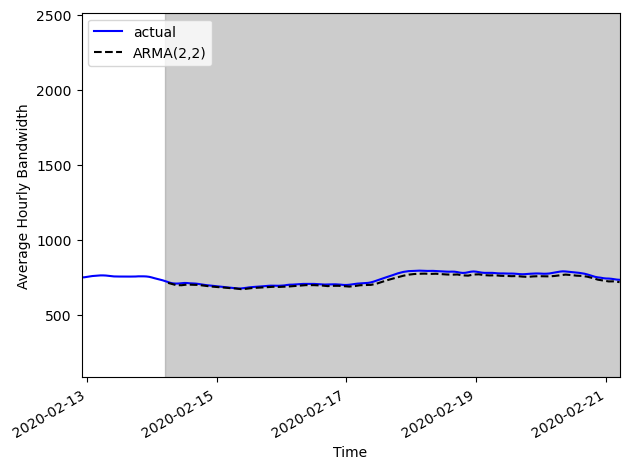

In [86]:
fig, ax = pt.subplots()

ax.plot(data['hourly_bandwidth'], 'b-', label='actual')
ax.plot(data['pred_bandwidth'], 'k--', label='ARMA(2,2)')
ax.set_xlabel('Time')
ax.set_ylabel('Average Hourly Bandwidth')
ax.legend(loc=2)
ax.axvspan(9831, 10000, color="#808080", alpha=0.4)
ax.set_xlim(9800, 9999)
pt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])
fig.autofmt_xdate()
pt.tight_layout()

Lastly, we can measure the mean absolute error (MAE) on the original dataset to get its meaning in a business context. Also, we can know that how much off are we from the original dataset.

In [88]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(data['hourly_bandwidth'][9832:], data['pred_bandwidth'][9832:])
print(mae)

14.000362776244973


This returns an MAE of 14, meaning that, on average, our forecasts are 14Mbps above or below the actual bandwidth usage. 

To wrap things up, ARMA model can effectively combine AR(p) model and MA(q) model and forecast more complex time series. It required us to define an entirely new modeling procedure and do not need to rely on the qualitative study of the ACF and PACF plots. Instead, we fit many ARMA(p,q) models with different (p,q) combinations and selected the model with the lowest AIC. Then we analyzed the model's residuals to make sure that their properties are similar to white noise: uncorrelated, normally distributed, and stationary. We can use another qualitative study to study the Q-Q plot to evaluate whether the residuals are normally distributed and can use a quantative method as well, Ljung-Box test to determine whether the residuals are correlated or not. 

# Summary 

- ARMA model is the combination of Autoregressive (AR) and Moving Average (MA)
- ARMA process will display a decaying pattern or a sinusoidal pattern on both ACF and PCF plots. Thus, cant be used to estimate the order
- ARMA does not rely on ACF and PACF plot, instead have a general modeling procedure by fitting many ARMA(p,q) models and perform model selection and residual analysis
- Model selection is done with Akaike Information Criterion (AIC). The lower the AIC, the better the model.
- The AIC is a relative measure of quality. It returns the best model among other models.
- Residual analysis is performed for an absoluate measure of quality. Residuals of a good model must approximate white noise, meaning that they must be uncorrelated, normally distributed, and independent.
- The Q-Q plot compares two distributions. We use it to compare the distribution of the residuals against a theoretical normal distribution. Straight line = normally distributed. Curve line = not normally distributed.
- The Ljung-Box test allows us to determine whether the residuals are correlated or not. The null hypothesis states that the data is independently distributed and uncorrelated. If the returned p-values are larger than 0.05, we cannot reject the null hypothesis, meaning that the residuals are uncorrelated just like white noise.